In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Improving Olist's Estimated Delivery Time (ETA)

Estimated Time Arrival (ETA) is a key component of modern e-commerce services. It allows to manage customer expectations by displaying a predicted date for customer delivery.

In this challenge we will build a predictive model to improve the Olist ETA prediction of orders `wait_time`, and compare it with Olist's `expected_wait_time`

## Load and check `orders` dataset

In [ ]:
# Load all orders from our training_data

In [ ]:
# import orders from tarining set. Include distance_seller_customer
orders = 

## Baseline Model - Olist’s current ETA model

❓ What's the baseline we want to optimize?

The delta between Olist' `expected_wait_time` and the real `wait_time`

Plot their respective histograms, median difference and RMSE

In [ ]:
# Plot distributions of expected_wait_time and real wait_time


In [ ]:
# Compute medians


In [ ]:
# Compute baseline RMSEs (i.e 𝛔(error_from_olist))


## OLS multivariate model

We will create an OLS model using the `statsmodel.api.OLS` method (not the `statsmodel.formula.api.ols`) this time.

### Prepare dataset of features X

In [ ]:
# Create target variable y (Series) and feature X (DataFrame) without data leaks!


In [ ]:
# standardize (z-normalize) each feature of X to compare coefficients


In [ ]:
# Check how different is it from the "formula" in statsmodel
import patsy
patsy.dmatrix('price + distance_seller_customer', orders)

In [ ]:
# Always add a constant "intercept" to your model

### Run OLS with statsmodels and print summary

In [ ]:
model = sm.OLS(y,X).fit()
model.summary()

## Check model performance

### Goodness of fit

In [ ]:
# Check prediction distributions

In [ ]:
# Compute RMSE (i.e 𝛔(residuals))

In [ ]:
# Visualize partial correlations with "sm.graphics.plot_partregress_grid"

**How to read these graphs (partial reg of `wait_time` against `distance` for instance)**

- Each point is an order in our dataset


- Y value is the residual of the `wait_time`, by using all features except `distance`

    - These residuals contain the remaining information about `wait_time` that couldn't be explained without `distance`


- X value is the residual of predicting `distance` by using all other features (price, freight_value, etc...)
    - These residuals contain the new information that `distance` brings to the table, which is not already explained by the other features in the model.



### Inferential conditions

❓ Check you residuals. Are they normally distributed?

❓A more precise way to visualize normality is the [QQplot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html). 
Plot the qqplot of your residual below, and make sure to understand the link with the histogram above.

Interpreting QQplots ([source](https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot))
- dots are arranged on `y-axis` in ascending order of values (y-axis = residual values)
- dots are spaced on `x-axis` proportionally to a "normal distribution"

In [ ]:
# Run cell below
sm.qqplot(residuals, line='s');

#### QQ plot examples

Run the cells below to understand how QQ plots are made

In [ ]:
from scipy import stats 
stats.norm.rvs(0,1)

In [ ]:
# lets check QQ plots with our own distributions
from scipy import stats

norm_1 = [stats.norm.rvs(0,1) for x in range(1000)]
norm_2 = [stats.norm.rvs(5,1) for x in range(1000)]

sns.distplot(norm_1)
sns.distplot(norm_2)
plt.xlim(right=10)

In [ ]:
sm.qqplot(np.asarray(norm_1), line='s');

In [ ]:
bimodal = norm_1 + norm_2
sns.distplot(bimodal)
plt.xlim(right=10)

In [ ]:
sm.qqplot(np.asarray(bimodal), line='s');

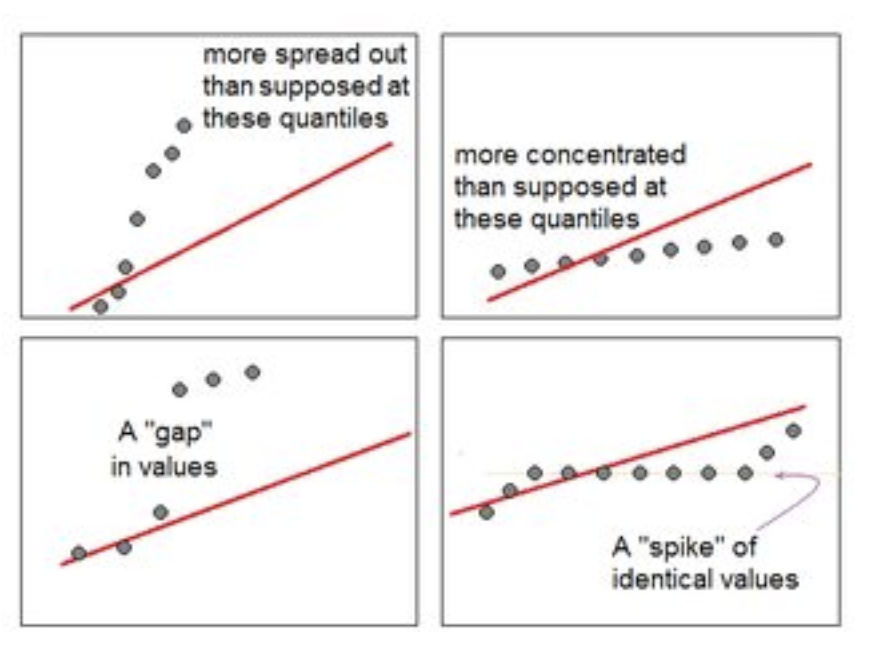

#### Finally, check your residuals vs. fitted to see if we can detect any non-random pattern

## Add more Features? (Optional)

Here we can add additional features from the product details (size, category etc..)

### Add product details associated with each order (sum of product sizes, sum of weights etc...)

In [65]:
from olist.data import Olist
data = Olist().get_data()
products = data['products']
order_items = data['order_items']

In [ ]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

In [ ]:
order_items_features = order_items_products.groupby("order_id", as_index=False).agg(
    {
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(columns={
        "product_weight_g": "product_weight_g_sum",
        "product_length_cm": "product_length_cm_max",
        "product_height_cm": "product_height_cm_max",
        "product_width_cm": "product_width_cm_max",
    })
order_items_features

In [83]:
orders_with_details = orders.merge(order_items_features, on="order_id", how="left").dropna()

In [76]:
X2 = orders_with_details[[
        "number_of_products",
        "number_of_sellers",
        "price",
        "freight_value",
        "distance_seller_customer",
        "product_weight_g_sum",
        "product_length_cm_max",
        "product_height_cm_max",
        "product_width_cm_max"]].copy()
y2 = orders_with_details["wait_time"].copy()

In [77]:
# standardize (z-normalize) each features of X to compare coefficients
for f in X2.columns:
    mu = X2[f].mean()
    sigma = X2[f].std()
    X2[f] = X2[f].map(lambda x: (x - mu) / sigma)

In [78]:
X2['constant'] = 1

In [79]:
model2 = sm.OLS(y2, X2).fit()

In [ ]:
model2.summary()